In [10]:
!export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:4096

In [1]:
import numpy as np
import os

from captum.attr import IntegratedGradients

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from custom_dataset import CustomDataset
from network import Network
from utils import *

In [2]:
torch.cuda.device_count()

1

In [3]:

parent_directory = '/data/users2/pnadigapusuresh1/JobOutputs'
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model = Network()
model.fc1 = nn.Sequential(nn.Linear(512,128),nn.ReLU(), nn.Dropout(0.1),
                nn.Linear(128,2),nn.ReLU())
model = nn.DataParallel(model)
model.to(device)

# Loading the model from Job 5436878
#loading model from 6066159
load_path = os.path.join(parent_directory,'6066159','models','epoch_170')

model.load_state_dict(torch.load(load_path))

Using cuda device


<All keys matched successfully>

In [4]:
#%%
########################
# Loading the Data #####
########################

torch.manual_seed(52)
np.random.seed(52)
# number of subprocesses to use for data loading
num_workers = 1
# how many samples per batch to load
batch_size = 15

In [5]:

valid_data = CustomDataset(train= False,test=False)

# get filtered variables
vars = valid_data.vars

valid_sampler = SubsetRandomSampler(list(range(len(vars))))

valid_loader = DataLoader(valid_data,batch_size=batch_size, 
                            sampler= valid_sampler, num_workers=num_workers)

In [6]:
len(vars)

4218

In [8]:
X,y = next(iter(valid_loader))
#X,y = X.to(device),y.to(device)

In [8]:
y

tensor([0])

In [8]:
ig = IntegratedGradients(model)

In [11]:
for X,y in valid_loader:
    X,y = X.to(device),y.to(device)
    X.requires_grad_()
    attr, delta = ig.attribute(torch.unsqueeze(X,1).float(),target=y, return_convergence_delta=True, 
                    internal_batch_size=4)
    attr = attr.detach().cpu().numpy()
    if y == 0:
        attr_0 = (attr_0 + attr)
    else:
        attr_1 = (attr_1 + attr)
    with open('attr_0.npy', 'wb') as f:
        np.save(f, attr_0)
    with open('attr_1.npy', 'wb') as f:
        np.save(f, attr_1)

# Testing the model Performance on the whole dataset

In [7]:
actual_valid = torch.tensor([]).to(device)
pred_valid = torch.tensor([]).to(device)
for X,y in valid_loader:
    X, y = X.to(device), y.to(device)
    actual_valid = torch.cat((actual_valid,y),0)
    pred = model(torch.unsqueeze(X,1).float())
    pred_valid = torch.cat((pred_valid,torch.argmax(pred,1)),0)

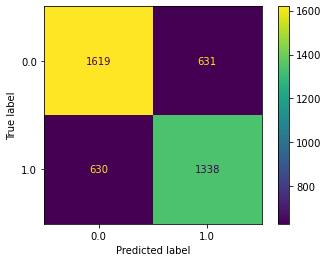

In [8]:
ConfusionMatrixDisplay.from_predictions(actual_valid.detach().cpu().numpy(),pred_valid.detach().cpu().numpy())

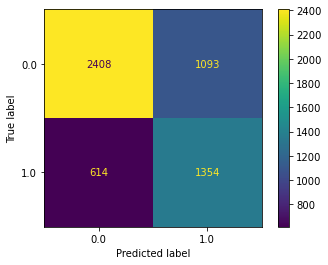

In [7]:
ConfusionMatrixDisplay.from_predictions(actual_valid.detach().cpu().numpy(),pred_valid.detach().cpu().numpy())

In [8]:
(2408 + 1356)/5469

0.6882428231852258

In [30]:
vars.new_score.value_counts()

0    3501
1    1968
Name: new_score, dtype: int64

In [9]:
from captum.attr import visualization as viz

In [11]:
from torch.utils.tensorboard import SummaryWriter
parent_directory = '/data/users2/pnadigapusuresh1/JobOutputs'
path = os.path.join(parent_directory,'Activations_1')
writer = SummaryWriter(log_dir=path)

In [2]:
attr_1 = np.load('attr_1.npy')
attr_0 = np.load('attr_0.npy')

In [3]:
attr_1.shape

(1, 1, 121, 145, 121)

In [4]:
attr_1 = attr_1/1968
attr_0 = attr_0/3501 

In [5]:
a1 = np.squeeze(attr_1)
a0 = np.squeeze(attr_0)

NameError: name 'X' is not defined

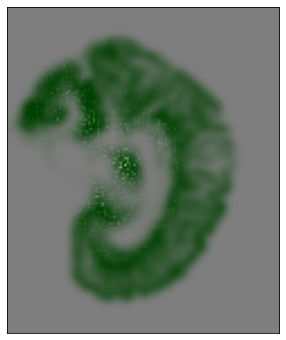

In [15]:
fig,axes = viz.visualize_image_attr(np.expand_dims(X[65],axis=2),np.expand_dims(a1[65],axis=2),method='blended_heat_map',sign='all')

In [150]:
for i in range(121):
    try:
        fig,axes = viz.visualize_image_attr(np.expand_dims(X[i],axis=2),np.expand_dims(attr_1[i],axis=2),method='blended_heat_map',sign = 'all')
        writer.add_figure('Slice',fig,i+1)
    except:
        print(i)

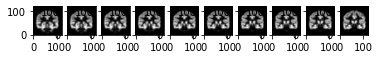

In [82]:
fig, axes = plt.subplots(1,10)
for i,j in enumerate(range(60,70)):
    axes[i].imshow(X[:,j,:].T,cmap="gray", origin="lower")

In [16]:
mask = np.abs(a1) > 1e-2

In [17]:
mask.shape

(121, 145, 121)

In [18]:
import json

In [19]:
with open('region_labels.json','r') as f:
    l = json.load(f)

In [20]:
labels = {v:{'attr_sum':0,'attrs':[]} for k,v in l.items()}

In [6]:
from nilearn.image import load_img 
imf = load_img('/trdapps/linux-x86_64/matlab/toolboxes/spm12/tpm/labels_Neuromorphometrics.nii').get_fdata()

In [7]:
imf = load_img('/trdapps/linux-x86_64/matlab/toolboxes/spm12/tpm/labels_Neuromorphometrics.nii').get_fdata()

In [8]:
str(int(imf[27,102,68]))

'142'

In [26]:
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        for k in range(X.shape[2]):
            if mask[i,j,k]:
                #print(i,j,k)
                r = imf[i,j,k]
                try:
                    labels[l[str(int(r))]]['attr_sum'] += np.abs(a1[i,j,k])
                    labels[l[str(int(r))]]['attrs'].append(np.abs(a1[i,j,k]))
                except KeyError:
                    print(r,(i,j,k))

0.0 (23, 41, 36)
0.0 (24, 41, 36)
0.0 (25, 37, 37)
0.0 (25, 43, 34)
0.0 (26, 37, 70)
0.0 (27, 41, 34)
0.0 (27, 87, 45)
0.0 (28, 77, 53)
0.0 (29, 29, 39)
0.0 (29, 81, 49)
0.0 (29, 83, 45)
0.0 (29, 85, 46)
0.0 (29, 85, 47)
0.0 (30, 67, 27)
0.0 (30, 81, 48)
0.0 (30, 81, 49)
0.0 (30, 83, 48)
0.0 (30, 89, 40)
0.0 (31, 27, 38)
0.0 (31, 29, 37)
0.0 (31, 29, 64)
0.0 (31, 52, 11)
0.0 (31, 67, 27)
0.0 (31, 88, 41)
0.0 (31, 89, 39)
0.0 (31, 102, 35)
0.0 (32, 65, 27)
0.0 (32, 71, 23)
0.0 (32, 87, 41)
0.0 (33, 71, 23)
0.0 (33, 90, 35)
0.0 (33, 100, 35)
0.0 (34, 60, 27)
0.0 (34, 62, 27)
0.0 (34, 97, 40)
0.0 (35, 91, 37)
0.0 (35, 99, 33)
0.0 (37, 54, 10)
0.0 (37, 62, 27)
0.0 (37, 69, 25)
0.0 (37, 71, 23)
0.0 (37, 97, 31)
0.0 (37, 97, 33)
0.0 (38, 54, 10)
0.0 (38, 58, 14)
0.0 (38, 62, 28)
0.0 (38, 66, 27)
0.0 (38, 77, 15)
0.0 (38, 89, 36)
0.0 (39, 50, 8)
0.0 (39, 64, 27)
0.0 (39, 77, 17)
0.0 (39, 89, 34)
0.0 (39, 89, 36)
0.0 (39, 91, 34)
0.0 (39, 91, 35)
0.0 (39, 94, 33)
0.0 (39, 94, 34)
0.0 (40, 64, 

In [84]:
min(labels['Right Cerebellum Exterior']['attrs']),max(labels['Right Cerebellum Exterior']['attrs'])

(0.01000229946638713, 0.08470488752043195)

In [111]:
[(v[0],v[1]['attr_sum']) for v in sorted(labels.items(),key=lambda x: x[1]['attr_sum'],reverse=True)]

[('Right Cerebellum Exterior', 80.07987710165466),
 ('Right Cerebral White Matter', 55.985100907112844),
 ('Right Thalamus Proper', 28.905400255250754),
 ('Left Thalamus Proper', 27.263603339788798),
 ('Left Cerebellum Exterior', 24.525292204609332),
 ('Right Hippocampus', 19.80746103145199),
 ('Left Cerebral White Matter', 17.478983070303038),
 ('Right Putamen', 17.17348198158862),
 ('Cerebellar Vermal Lobules I-V', 11.94387406493882),
 ('Right FuG fusiform gyrus', 11.549365285133428),
 ('Right Caudate', 11.040217044243926),
 ('Right PHG parahippocampal gyrus', 8.893181740923541),
 ('Left Hippocampus', 8.321538694487874),
 ('Brain Stem', 8.176688524775976),
 ('Left Putamen', 8.028699596565756),
 ('Right Cerebellum White Matter', 7.951524014134662),
 ('Right LiG lingual gyrus', 7.733014207553727),
 ('Left PCgG posterior cingulate gyrus', 6.816163231523231),
 ('Left Caudate', 6.7651431210843),
 ('Right PCgG posterior cingulate gyrus', 6.673354589236982),
 ('Right AIns anterior insula', 

In [31]:
labels_0 = {v:{'attr_sum':0,'attrs':[]} for k,v in l.items()}

In [32]:
mask_0 = np.abs(a0) > 1e-2

In [33]:
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        for k in range(X.shape[2]):
            if mask_0[i,j,k]:
                #print(i,j,k)
                r = imf[i,j,k]
                try:
                    labels_0[l[str(int(r))]]['attr_sum'] += np.abs(a0[i,j,k])
                    labels_0[l[str(int(r))]]['attrs'].append(np.abs(a0[i,j,k]))
                except KeyError:
                    print(r,(i,j,k))

0.0 (23, 39, 38)
0.0 (23, 41, 36)
0.0 (24, 39, 38)
0.0 (24, 41, 36)
0.0 (24, 47, 31)
0.0 (25, 37, 37)
0.0 (25, 37, 38)
0.0 (25, 39, 36)
0.0 (25, 43, 34)
0.0 (26, 37, 70)
0.0 (26, 43, 33)
0.0 (27, 41, 34)
0.0 (27, 87, 45)
0.0 (28, 77, 53)
0.0 (28, 81, 49)
0.0 (29, 29, 39)
0.0 (29, 77, 53)
0.0 (29, 78, 53)
0.0 (29, 81, 49)
0.0 (29, 83, 45)
0.0 (29, 85, 44)
0.0 (29, 85, 46)
0.0 (29, 85, 47)
0.0 (30, 81, 49)
0.0 (30, 89, 40)
0.0 (31, 27, 38)
0.0 (31, 29, 37)
0.0 (31, 52, 11)
0.0 (31, 67, 27)
0.0 (31, 89, 39)
0.0 (31, 102, 35)
0.0 (32, 65, 27)
0.0 (32, 87, 41)
0.0 (33, 71, 23)
0.0 (33, 100, 35)
0.0 (34, 62, 27)
0.0 (34, 72, 21)
0.0 (35, 91, 37)
0.0 (36, 57, 14)
0.0 (36, 62, 26)
0.0 (36, 68, 25)
0.0 (36, 73, 20)
0.0 (37, 62, 27)
0.0 (37, 69, 25)
0.0 (37, 71, 23)
0.0 (37, 97, 31)
0.0 (37, 97, 33)
0.0 (38, 54, 10)
0.0 (38, 58, 14)
0.0 (38, 58, 16)
0.0 (38, 62, 28)
0.0 (38, 65, 27)
0.0 (38, 66, 27)
0.0 (38, 73, 22)
0.0 (38, 77, 15)
0.0 (38, 89, 36)
0.0 (38, 90, 34)
0.0 (38, 90, 35)
0.0 (39, 58,

In [34]:
[(v[0],v[1]['attr_sum']) for v in sorted(labels_0.items(),key=lambda x: x[1]['attr_sum'],reverse=True)]

[('Right Cerebellum Exterior', 91.3081963059494),
 ('Right Cerebral White Matter', 58.53489866825186),
 ('Right Thalamus Proper', 29.650356414100948),
 ('Left Cerebellum Exterior', 29.31489367723776),
 ('Left Thalamus Proper', 27.685502860605045),
 ('Right Hippocampus', 20.77422217848075),
 ('Right Putamen', 18.205920170767705),
 ('Left Cerebral White Matter', 18.143357661280447),
 ('Cerebellar Vermal Lobules I-V', 13.210662492039019),
 ('Right FuG fusiform gyrus', 12.71201759239001),
 ('Right Caudate', 10.599116323605987),
 ('Right PHG parahippocampal gyrus', 9.548372999277147),
 ('Right Cerebellum White Matter', 9.109030079485803),
 ('Brain Stem', 9.03071099663909),
 ('Left Hippocampus', 8.928911623094322),
 ('Right LiG lingual gyrus', 8.243262892277983),
 ('Left Putamen', 7.94650012095069),
 ('Right PCgG posterior cingulate gyrus', 7.197840235913656),
 ('Left PCgG posterior cingulate gyrus', 6.857421765841525),
 ('Left Caudate', 6.5138507931458145),
 ('Cerebellar Vermal Lobules VIII

In [59]:
l_cerebellum_exterior = imf == 57

In [60]:
l_cerebellum_exterior.astype(int)

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [61]:
affine = np.array([[  -1.5,    0. ,    0. ,   90. ],
       [   0. ,    1.5,    0. , -126. ],
       [   0. ,    0. ,    1.5,  -72. ],
       [   0. ,    0. ,    0. ,    1. ]])

In [17]:
import nibabel as nib

In [62]:
array_img = nib.Nifti1Image(l_cerebellum_exterior.astype(int), affine)

In [58]:
nib.save(array_img,'r_putamen.nii')

In [35]:
vars.new_score.value_counts()

0    3501
1    1968
Name: new_score, dtype: int64

Text(0, 0.5, 'Number of subjects')

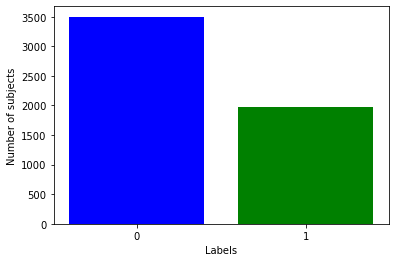

In [47]:
from matplotlib import pyplot as plt 

plt.bar(['0','1'],[3501,1968],color=['blue','green'])
plt.xlabel('Labels')
plt.ylabel('Number of subjects')
#plt.title('Bar plot showing the distribution of lower and higher group ends')


In [38]:
vars.score.value_counts()

5.0     2465
9.0     1582
4.0      800
10.0     339
3.0      158
2.0       78
11.0      39
12.0       8
Name: score, dtype: int64

In [41]:
['green'] * 4

['green', 'green', 'green', 'green']

Text(0, 0.5, 'Number of subjects')

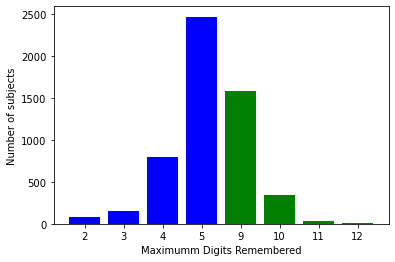

In [48]:
plt.bar(['2','3','4','5','9','10','11','12'],[78,158,800,2465,1582,339,39,8],color = ['blue', 'blue', 'blue', 'blue','green', 'green', 'green', 'green' ])
plt.xlabel('Maximumm Digits Remembered')
plt.ylabel('Number of subjects')

In [49]:
3501 + 1968

5469